<a href="https://colab.research.google.com/github/Taophycc/NVIDIA-iQuHACK-2026/blob/main/qaoa_labs_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os, sys
from google.colab import drive

# 1. Connect to your Drive (Click the link/allow access)
drive.mount('/content/drive')

# 2. Add your Drive folder to the Python path
nb_path = '/content/drive/MyDrive/colab_packages'
if nb_path not in sys.path:
    sys.path.insert(0, nb_path)

# 3. Import and Verify
import cudaq
print("✅ CUDA-Q loaded successfully from Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CUDA-Q loaded successfully from Drive!


🚀 Initializing Proper LABS QAOA for N=25...
Starting GPU-Accelerated Optimization (N=25)...
--- Run 1/3 ---
Run 1 Energy: 299.9994
--- Run 2/3 ---
Run 2 Energy: 299.9992
--- Run 3/3 ---
Run 3 Energy: 299.9996

Sampling the circuit with optimized parameters...
Starting Classical Refinement on Quantum Seed...
✅ Improved Energy: 496
✅ Improved Energy: 484
✅ Improved Energy: 432
✅ Improved Energy: 400
✅ Improved Energy: 384
✅ Improved Energy: 308
✅ Improved Energy: 304
✅ Improved Energy: 256
✅ Improved Energy: 164
✅ Improved Energy: 148
✅ Improved Energy: 144
✅ Improved Energy: 100
✅ Improved Energy: 96
✅ Improved Energy: 84

🚀 HYBRID RESULTS COMPLETE
Refined Final Energy: 84
Final Merit Factor (MF): 3.7202
Quantum Seed Energy: [1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1]


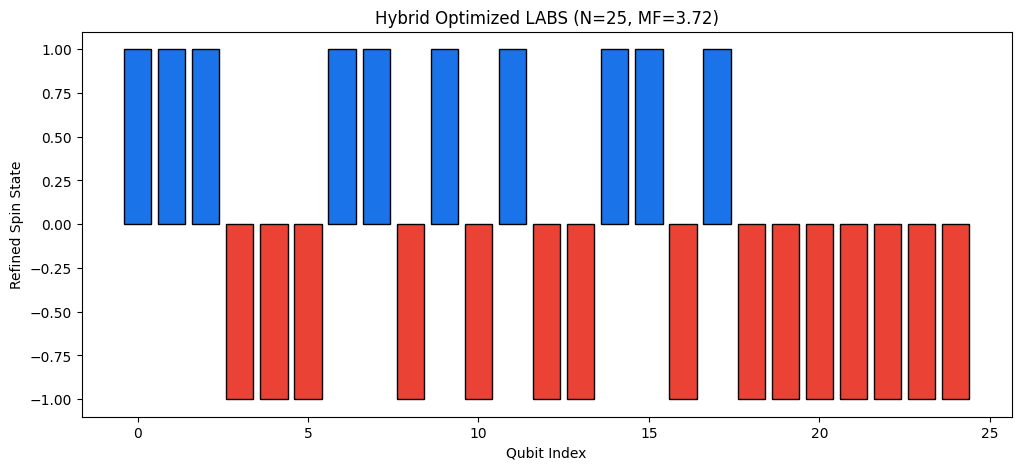

In [10]:
import cudaq
from cudaq import spin
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. SETUP & CONFIGURATION
N = 25              # Sequence length (Number of qubits)
STEPS = 1           # QAOA layers (p)
NUM_RUNS = 3        # Multi-start optimization runs
np.random.seed(42)  # For reproducibility

print(f"🚀 Initializing Proper LABS QAOA for N={N}...")

# 2. HAMILTONIAN GENERATION (The Physics)
def get_labs_hamiltonian(n_val):
    """Maps the squared autocorrelation function to a 4-qubit Spin Operator."""
    ham = 0 * spin.z(0)
    for k in range(1, n_val):
        for i in range(n_val - k):
            for j in range(n_val - k):
                # Mapping s_i * s_{i+k} * s_j * s_{j+k}
                ham += spin.z(i) * spin.z(i+k) * spin.z(j) * spin.z(j+k)
    return ham

ham_obj = get_labs_hamiltonian(N)

# 3. QUANTUM KERNEL (The Circuit)
def build_qaoa_kernel(n_qubits, p_steps):
    """Constructs the QAOA circuit using make_kernel for stability."""
    kernel, params = cudaq.make_kernel(list)
    q = kernel.qalloc(n_qubits)

    # Step 1: Superposition (Start with all possible sequences)
    kernel.h(q)

    # Step 2: Alternating Layers
    for step in range(p_steps):
        # COST LAYER: Approximate phase rotation based on interactions
        for i in range(n_qubits - 1):
            kernel.cx(q[i], q[i+1])
            kernel.rz(params[step], q[i+1])
            kernel.cx(q[i], q[i+1])

        # MIXER LAYER: Allows tunneling through energy barriers
        for i in range(n_qubits):
            kernel.rx(params[step + p_steps], q[i])

    return kernel

qaoa_kernel = build_qaoa_kernel(N, STEPS)

# 4. OBJECTIVE FUNCTION
def objective(angles):
    """Returns the expectation value (Energy) from the GPU simulator."""
    result = cudaq.observe(qaoa_kernel, ham_obj, angles)
    return result.expectation()

# 5. MULTI-START OPTIMIZATION
print(f"Starting GPU-Accelerated Optimization (N={N})...")
best_final_energy = float('inf')
best_params = None

for run in range(NUM_RUNS):
    print(f"--- Run {run+1}/{NUM_RUNS} ---")
    initial_guess = np.random.uniform(-0.5, 0.5, 2 * STEPS)

    current_res = minimize(
        objective,
        x0=initial_guess,
        method='COBYLA',
        options={'maxiter': 50},
        tol=1e-3
    )
    print(f"Run {run+1} Energy: {current_res.fun:.4f}")

    if current_res.fun < best_final_energy:
        best_final_energy = current_res.fun
        best_params = current_res.x

class OptimizationResult:
    def __init__(self, fun, x):
        self.fun, self.x = fun, x

res = OptimizationResult(best_final_energy, best_params)

# 6. EXTRACTION (Sampling the Bitstring)
print("\nSampling the circuit with optimized parameters...")
counts = cudaq.sample(qaoa_kernel, res.x.tolist())

best_bitstring = ""
max_count = -1

for bitstring, count in counts.items():
    if count > max_count:
        max_count = count
        best_bitstring = bitstring

final_sequence = [1 if bit == '0' else -1 for bit in best_bitstring]

# 7. HYBRID REFINEMENT (Classical Local Search)
def calculate_energy(s):
    L = len(s)
    return sum(sum(s[i] * s[i+k] for i in range(L-k))**2 for k in range(1, L))

def hill_climbing_refiner(quantum_seed):
    print(f"Starting Classical Refinement on Quantum Seed...")
    current_s = list(quantum_seed)
    current_e = calculate_energy(current_s)
    n = len(current_s)
    improved = True

    while improved:
        improved = False
        for i in range(n):
            current_s[i] *= -1 # Flip bit
            new_e = calculate_energy(current_s)
            if new_e < current_e:
                current_e = new_e
                improved = True
                print(f"✅ Improved Energy: {current_e}")
                break
            else:
                current_s[i] *= -1
    return current_s, current_e

# Run the refiner
refined_seq, refined_energy = hill_climbing_refiner(final_sequence)
merit_factor = (N**2) / (2 * refined_energy)

print(f"\n🚀 HYBRID RESULTS COMPLETE")
print(f"Refined Final Energy: {refined_energy}")
print(f"Final Merit Factor (MF): {merit_factor:.4f}")
print(f"Quantum Seed Energy: {refined_seq}")


# 8. UPDATED VISUALIZATION
plt.figure(figsize=(12, 5))
colors = ['#1a73e8' if x == 1 else '#ea4335' for x in refined_seq]
plt.bar(range(N), refined_seq, color=colors, edgecolor='black')
plt.title(f"Hybrid Optimized LABS (N={N}, MF={merit_factor:.2f})")
plt.xlabel("Qubit Index")
plt.ylabel("Refined Spin State")
plt.show()